<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-END-Program/blob/main/10-%20HandsOn%204/RNN_attention_based_machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN based machine translation - English to German

In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 1.2MB 12.7MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


NameError: ignored

In [3]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Extension of Flickr30K dataset. Contains German trnaslations of English descriptions.
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import time
import math

print(torchtext.__version__)

0.6.0


In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Download and load spacy models for DE and EN.

In [5]:
# Download and load spacy models for DE and EN languages. To be used for tokenization.
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=08667c4f6754508ac3b9feabd7009e69fcf271b337f92bb6de49617a514bdfae
  Stored in directory: /tmp/pip-ephem-wheel-cache-csn6s1m6/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [6]:
# After linking spacy.load('de_core_news_sm') -> spacy.load('de')
spacy_de = spacy.load('de')
# After linking spacy.load('en_core_web_sm') -> spacy.load('en')
spacy_en = spacy.load('en')

### Prepare tokenizers

Takes in string and returns list of tokens. Will be passed to torchtext.


In [7]:
# Tokenizer for German. 
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Prepare FIELDS

Defines a datatype together with instructions for converting to Tensor. holds a Vocab object that defines the set of possible values
    for elements of the field and their corresponding numerical representations.

SRC is English and TRG is German.

In [8]:
SRC = Field(tokenize = tokenize_en, init_token = '<SOS>', eos_token = '<EOS>', lower = True)
TRG = Field(tokenize = tokenize_de, init_token = '<SOS>', eos_token = '<EOS>', lower = True)


In [9]:
SRC.__dict__

{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<EOS>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<SOS>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'tokenizer_args': (<function __main__.tokenize_en>, 'en'),
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True}

### Download Multi30K dataset and load train, test and val data.

In [10]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.de'), fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 514kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 170kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


In [11]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [12]:
print(vars(train_data.examples[0]))

{'src': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], 'trg': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']}


### Build vocabulary for SRC and TRG

Vocabulary will associate each unique tokens with an index. Only tokens that appear atleast 2 times are considered. Other such words are replaced by <UNK>. Vocab object built on only training examples.

In [13]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [14]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 5893
Unique tokens in target (en) vocabulary: 7855


In [15]:
# SRC.vocab dict has the following keys - freqs(provides word and its frequencies), itos(mapping of integer to string), 
# stoi(mapping of string to its integer) and vectors()
print(SRC.vocab.__dict__.keys())
SRC.vocab.__dict__

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])


{'freqs': Counter({'two': 3886,
          'young': 2280,
          ',': 3963,
          'white': 2238,
          'males': 40,
          'are': 3717,
          'outside': 871,
          'near': 571,
          'many': 222,
          'bushes': 19,
          '.': 27623,
          'several': 404,
          'men': 1759,
          'in': 14886,
          'hard': 123,
          'hats': 146,
          'operating': 22,
          'a': 49165,
          'giant': 45,
          'pulley': 3,
          'system': 6,
          'little': 916,
          'girl': 1723,
          'climbing': 193,
          'into': 711,
          'wooden': 175,
          'playhouse': 3,
          'man': 7781,
          'blue': 1880,
          'shirt': 2324,
          'is': 7525,
          'standing': 1614,
          'on': 8035,
          'ladder': 60,
          'cleaning': 60,
          'window': 183,
          'at': 2927,
          'the': 10955,
          'stove': 23,
          'preparing': 105,
          'food': 357,
        

### Create iterators for train, valid and test.

BucketIterator is used instead of Standard Iterator. BucketIterator defines an iterator that batches examples of similar lengths together.

Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.

batch.src - [ (128) , (128), .. 23 times]**bold text**

In [16]:
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

device

device(type='cuda')

In [17]:
batch = next(iter(train_iterator))
print(batch,"\n")
print(f"Source sequence of shape [src_len, batch_size]-{batch.trg.shape} \n",batch.src)
print(f"Target of shape [src_len, batch_size]-{batch.trg.shape} \n",batch.trg)


[torchtext.data.batch.Batch of size 128 from MULTI30K]
	[.src]:[torch.cuda.LongTensor of size 21x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 23x128 (GPU 0)] 

Source sequence of shape [src_len, batch_size]-torch.Size([23, 128]) 
 tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [  14,   19,    4,  ...,    4,    4,    9],
        [  13, 1693,  192,  ...,   38,    9,   22],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')
Target of shape [src_len, batch_size]-torch.Size([23, 128]) 
 tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   8,   54,    5,  ...,    8,    5,    5],
        [  16, 1552,  717,  ...,   36,   13,   13],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')


### Build model


#### Encoder

Bidirectional GRUs are being used to encode the source sequence.

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        # src = [src_len, batch_size]
        embedding = self.dropout(self.embedding(src))
        # embedding = [src_len, batch_size, emb_dim]
        outputs, hidden = self.rnn(embedding)
        # outputs = [src_len, batch_size, num_direction * enc_hid_dim]
        # hidden = [num_layers*num_direction, batch_size, enc_hid_dim]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        # hidden = [batch_size, dec_hid_dim]
        # outputs = [src_len, batch_size, num_direction * enc_hid_dim]
        return outputs, hidden

#### Attention

In [19]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim *2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden - decoder hidden state- s(t-1) [batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, enc_hid_dim*2]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch_size, dec_hid_dim] -> [batch_size, 1, dec_hid_dim] -> [batch_size, src_len, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, 2*enc_hid_dim] -> [batch_size, src_len, 2*enc_hid_dim]

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2 )))
        # energy = [batch_size, src_len, dec_hid_dim]
        attention = self.v(energy).squeeze(2)
        # attention = [batch_size, src_len]
        return F.softmax(attention, dim=1)

#### Decoder

In [20]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.attention = attention
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(enc_hid_dim*2 + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear(enc_hid_dim*2 + emb_dim + dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, encoder_outputs):
        # input = [batch_size]
        # hidden = [batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, 2*enc_hid_dim]

        input = input.unsqueeze(0)
        # input = [1, batch_size]

        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]

        a = self.attention(hidden, encoder_outputs)
        # a = [batch_size, src_len]
        a = a.unsqueeze(1)
        # a = [batch_size, 1, src_len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch_size, src_len, enc_hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch_size, 1, enc_hid_dim*2]
        weighted = weighted.permute(1, 0, 2)        
        # weighted = [1, batch_size, enc_hid_dim * 2]

        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch_size, enc_hid_dim*2 + emb_dim]

        # hidden.unsqueeze(0) = [1, batch_size, dec_hid_dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [1, batch_size, dec_hid_dim]
        # hidden = [1, batch_size, dec_hid_dim]

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, embedded, weighted), dim = 1))
        #prediction = [batch_size, output_dim]

        return prediction, hidden.squeeze(0), a.squeeze(1)


#### Seq2Seq model

In [21]:
# build seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder output
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Last hidden state of the encoder is the context
        encoder_outputs, hidden = self.encoder(src)

        # first input to the decoder is <sos> token
        input = trg[0,:]

        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            # decide of teacher forcing is going to be used
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

### Training Seq2Seq model

In [22]:
INPUT_DIM = len(SRC.vocab) # 5893
OUTPUT_DIM = len(TRG.vocab) # 7855
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [23]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(7855, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=7855, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters') 

The model has 24,036,783 trainable parameters


### Define optimizer and criterion

In [25]:
optimizer = optim.Adam(model.parameters())

In [26]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training loop

In [27]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)
 
        #trg = [trg_len, batch_size]
        #output = [trg_len, batch_size, output_dim]

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [28]:
def evaluate(model, iterator, criterion):    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) # Turning off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
N_EPOCHS = 25
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 36s
	Train Loss: 5.083 | Train PPL: 161.254
	 Val. Loss: 5.004 |  Val. PPL: 148.944
Epoch: 02 | Time: 1m 38s
	Train Loss: 4.078 | Train PPL:  59.007
	 Val. Loss: 4.197 |  Val. PPL:  66.496
Epoch: 03 | Time: 1m 38s
	Train Loss: 3.397 | Train PPL:  29.862
	 Val. Loss: 3.575 |  Val. PPL:  35.710
Epoch: 04 | Time: 1m 38s
	Train Loss: 2.818 | Train PPL:  16.748
	 Val. Loss: 3.293 |  Val. PPL:  26.933
Epoch: 05 | Time: 1m 39s
	Train Loss: 2.394 | Train PPL:  10.955
	 Val. Loss: 3.178 |  Val. PPL:  24.009
Epoch: 06 | Time: 1m 38s
	Train Loss: 2.078 | Train PPL:   7.990
	 Val. Loss: 3.048 |  Val. PPL:  21.069
Epoch: 07 | Time: 1m 38s
	Train Loss: 1.808 | Train PPL:   6.100
	 Val. Loss: 3.065 |  Val. PPL:  21.427
Epoch: 08 | Time: 1m 39s
	Train Loss: 1.611 | Train PPL:   5.006
	 Val. Loss: 3.159 |  Val. PPL:  23.536
Epoch: 09 | Time: 1m 38s
	Train Loss: 1.443 | Train PPL:   4.232
	 Val. Loss: 3.169 |  Val. PPL:  23.778
Epoch: 10 | Time: 1m 37s
	Train Loss: 1.318 | Train PPL

### Run results

In [47]:
train_loss_all = [5.083, 4.078, 3.397, 2.818, 2.394, 2.078, 1.808, 1.611, 1.443, 1.318, 1.219, 1.115, 1.029, 0.943, 0.876, 0.819, 0.746, 0.690, 0.641, 0.601, 0.547, 0.526, 0.491, 0.453, 0.438]
valid_loss_all = [5.004, 4.197, 3.575, 3.293, 3.178, 3.048, 3.065, 3.159, 3.169, 3.180, 3.264, 3.298, 3.361, 3.442, 3.465, 3.606, 3.665, 3.714, 3.833, 3.867, 4.015, 4.009, 4.076, 4.203, 4.212]

In [54]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, valid_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(valid_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch curve")
    plt.legend(loc='best')
    plt.show()

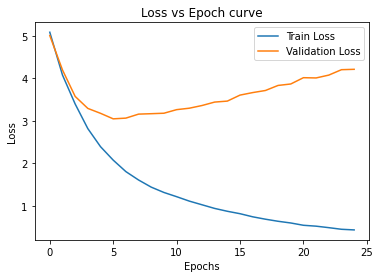

In [55]:
train_test_metrics_graph(train_loss_all, valid_loss_all)

### Test

In [31]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.044 | Test PPL:  20.996 |


### Inference

Following activities are carried out in inference


* ensure our model is in evaluation mode, which it should always be for inference
* tokenize the source sentence if it has not been tokenized (is a string)
* numericalize the source sentence
* convert it to a tensor and add a batch dimension
* feed the source sentence into the encoder
* create a list to hold the output sentence, initialized with an <sos> token
* create a tensor to hold the attention values
* while we have not hit a maximum length
    * get the input tensor, which should be either <sos> or the last predicted token
    * feed the input, all encoder outputs, hidden state into the decoder
    * store attention values
    * get the predicted next token
    * add prediction to current output sentence prediction
    * break if the prediction was an <eos> token
* convert the output sentence from indexes to tokens
* return the output sentence (with the <sos> token removed) and the attention values over the sequence

In [44]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
    # If sentence is a string, tokenise the string. Else, if a list 
    if isinstance(sentence, str):
        tokens = [token.lower() for token in tokenize_en(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    # Add start of sentence and end of sentence to the tokens
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    # Numericalize the source sentence
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    # src_indexes shape = [src_len]

    # Convert to tensor and add batch dimension.
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # src_tensor shape = [src_len, batch_size]
    # print("Is model on cuda?", next(model.parameters()).is_cuda)
    # print("Is source tensor on cuda?",src_tensor.is_cuda)

    # Feed source sentence into encoder
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
    
    # create a list to hold the output sentence, initialized with an <sos> token
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    # create a tensor to hold the attention values
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [33]:
# check
SRC.vocab.stoi["hello"]
s1 = [token.lower() for token in tokenize_en("Hello from other side")]
s2 = [SRC.vocab.stoi[token] for token in s1]
s3 = torch.LongTensor(s2).unsqueeze(1)
s3.shape

torch.Size([4, 1])

In [34]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

### Inference example on example

In [35]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']
trg = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']


In [36]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

Is model on cuda? True
Is source tensor on cuda? True
predicted trg = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', 'spielerisch', '.', '<EOS>']


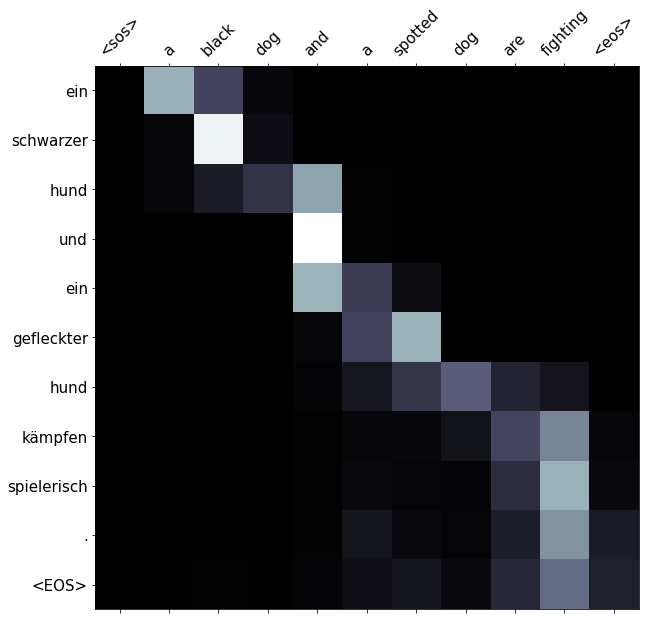

In [37]:
display_attention(src, translation, attention)

### Example from validation dataset

In [38]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']
trg = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']


Is model on cuda? True
Is source tensor on cuda? True
predicted trg = ['eine', 'frau', 'spielt', 'auf', 'der', 'bühne', 'und', 'spielt', 'auf', '.', '<EOS>']


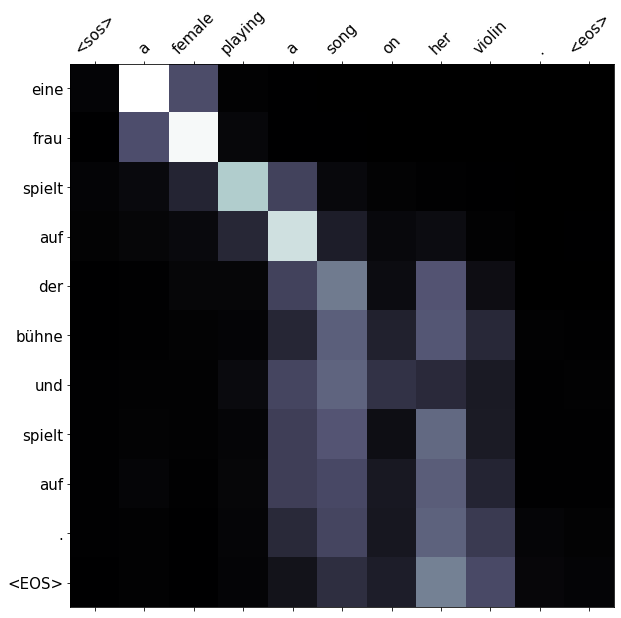

In [39]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [40]:
example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']
trg = ['die', 'person', 'im', 'gestreiften', 'shirt', 'klettert', 'auf', 'einen', 'berg', '.']


Is model on cuda? True
Is source tensor on cuda? True
predicted trg = ['die', 'person', 'im', 'gestreiften', 'hemd', 'klettert', 'auf', 'dem', '.', '<EOS>']


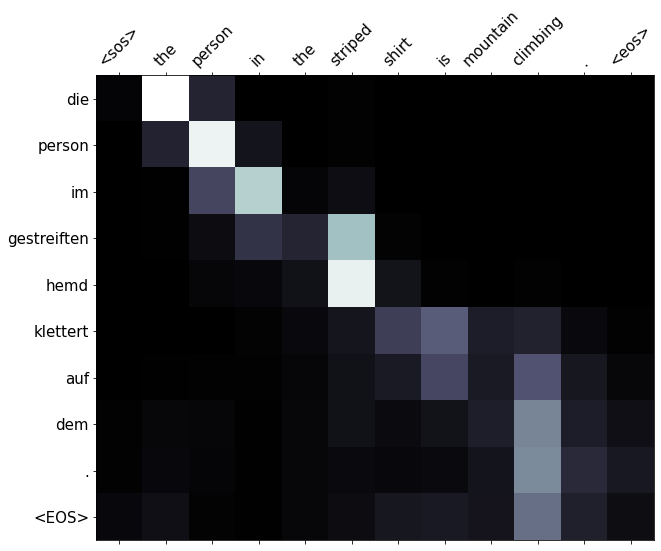

In [41]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### Bleu score

In [45]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [46]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 27.15
